# 1. Business Understanding
- Mengembangkan Model SImulasi Otomatisasi HIdroponik mas dengan model Prophet dan Arima
- Membandingkan 2 Metode Algoritma Prophet dan ARIMA mana yang terbaik dan efektif.
- Mengembangkan Aplikasi Simulasi Hidroponik (HydroSim) untuk mlakukan simulasi otomasisasi hidroponik tanaman selada dengan menggunakan model terbaik


# 2. Data Understanding

In [143]:
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from tabulate import tabulate
from sklearn.metrics import confusion_matrix

## Load Dataset

In [3]:
df = pd.read_csv("/content/DataTrainSIOHIFull.csv")

In [4]:
df.head()

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,Label,LeafCount
0,1,1,9.28,25.1,89,28330,6.7,686,343,26.8,Selada,4
1,1,2,9.29,25.3,89,29231,6.7,686,343,26.8,Selada,3
2,1,3,9.31,25.5,89,27850,6.7,686,343,26.8,Selada,3
3,1,4,9.32,25.7,89,25030,6.7,678,334,26.8,Selada,3
4,1,5,9.33,25.9,89,22280,6.7,686,343,26.8,Selada,4


In [5]:
df.tail()

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,Label,LeafCount
4795,40,6,16.38,26.7,87,13640,7.4,1851,930,26.3,Selada,13
4796,40,7,16.42,26.8,87,14750,7.4,1801,902,26.3,Selada,15
4797,40,8,16.43,26.7,87,18860,7.4,1886,943,26.3,Selada,18
4798,40,9,16.44,25.9,87,12970,7.4,1801,902,26.3,Selada,15
4799,40,10,16.45,25.6,87,17080,7.4,1851,930,26.3,Selada,14


### EDA

In [6]:
df.columns

Index(['day', 'hole', 'time', 'temperature', 'humidity', 'light', 'pH', 'EC',
       'TDS', 'WaterTemp', 'Label', 'LeafCount'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          4800 non-null   int64  
 1   hole         4800 non-null   int64  
 2   time         4800 non-null   float64
 3   temperature  4800 non-null   float64
 4   humidity     4800 non-null   int64  
 5   light        4800 non-null   int64  
 6   pH           4800 non-null   float64
 7   EC           4800 non-null   int64  
 8   TDS          4800 non-null   int64  
 9   WaterTemp    4800 non-null   float64
 10  Label        4800 non-null   object 
 11  LeafCount    4800 non-null   int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 450.1+ KB


In [8]:
# Check missing data

missing_data = pd.DataFrame({'total_missing': df.isnull().sum(),
                             'perc_missing': (df.isnull().sum()/2634)*100})

missing_data

,total_missing,perc_missing
day,0,0.0
hole,0,0.0
time,0,0.0
temperature,0,0.0
humidity,0,0.0
light,0,0.0
pH,0,0.0
EC,0,0.0
TDS,0,0.0
WaterTemp,0,0.0


In [9]:
df.describe()

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,LeafCount
count,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000
mean,20.500000,5.500000,12.892369,26.933708,73.687500,23258.189375,7.078500,1239.908958,619.317292,27.601250,8.232083
std,11.544599,2.872581,2.711500,1.925072,18.090274,15414.390490,0.222706,448.454247,223.270654,3.097317,4.086771
min,1.000000,1.000000,8.450000,23.100000,40.000000,9003.000000,6.400000,608.000000,304.000000,22.900000,3.000000
25%,10.750000,3.000000,11.020000,25.600000,58.000000,9971.000000,6.900000,677.000000,340.000000,26.200000,5.000000
50%,20.500000,5.500000,13.220000,26.600000,70.000000,17080.000000,7.100000,1317.000000,654.500000,26.750000,7.000000
75%,30.250000,8.000000,14.835000,27.500000,91.000000,32527.500000,7.200000,1589.000000,794.000000,30.400000,11.000000
max,40.000000,10.000000,16.530000,32.600000,99.000000,59620.000000,7.400000,1892.000000,946.000000,34.100000,19.000000


In [10]:
df = df.drop(columns=['Label'])

In [11]:
# Correlation Matrix
cor_matrix = df.corr()
cor_matrix

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,LeafCount
day,1.000000e+00,4.321791e-17,0.005146,-0.237878,2.967831e-01,-0.611500,0.516092,0.947434,0.947201,-4.478751e-01,0.901808
hole,4.321791e-17,1.000000e+00,0.036017,0.023434,4.313680e-17,-0.049853,0.036937,-0.000372,0.001268,-3.419743e-17,-0.011910
time,5.145883e-03,3.601701e-02,1.000000,0.040850,-2.583335e-01,0.206292,0.264329,0.007085,0.005652,5.975731e-01,-0.000647
temperature,-2.378779e-01,2.343423e-02,0.040850,1.000000,-2.364883e-01,0.294880,-0.024166,-0.271560,-0.268944,3.787264e-01,-0.229699
humidity,2.967831e-01,4.313680e-17,-0.258333,-0.236488,1.000000e+00,-0.429313,0.166406,0.301457,0.299237,-6.063652e-01,0.250768
light,-6.115000e-01,-4.985327e-02,0.206292,0.294880,-4.293133e-01,1.000000,-0.222756,-0.633659,-0.633310,7.070617e-01,-0.550859
pH,5.160923e-01,3.693666e-02,0.264329,-0.024166,1.664064e-01,-0.222756,1.000000,0.535945,0.537709,-8.571127e-02,0.447421
EC,9.474342e-01,-3.721184e-04,0.007085,-0.271560,3.014568e-01,-0.633659,0.535945,1.000000,0.998912,-4.875125e-01,0.849487
TDS,9.472013e-01,1.267585e-03,0.005652,-0.268944,2.992370e-01,-0.633310,0.537709,0.998912,1.000000,-4.868266e-01,0.850293
WaterTemp,-4.478751e-01,-3.419743e-17,0.597573,0.378726,-6.063652e-01,0.707062,-0.085711,-0.487513,-0.486827,1.000000e+00,-0.416076


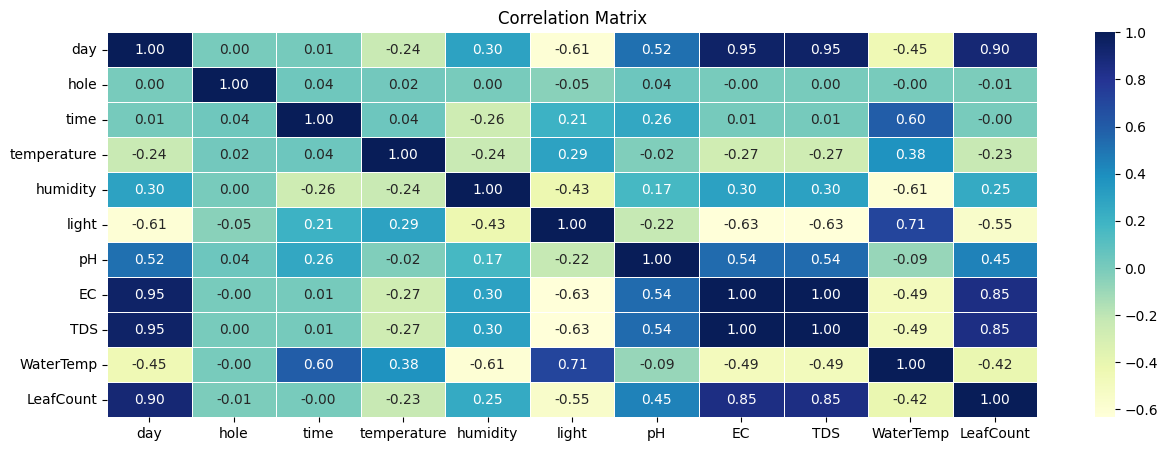

In [ ]:
# Heatmap of the correlation matrix
plt.figure(figsize=(15, 5))
sns.heatmap(cor_matrix, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

### Visualisasi

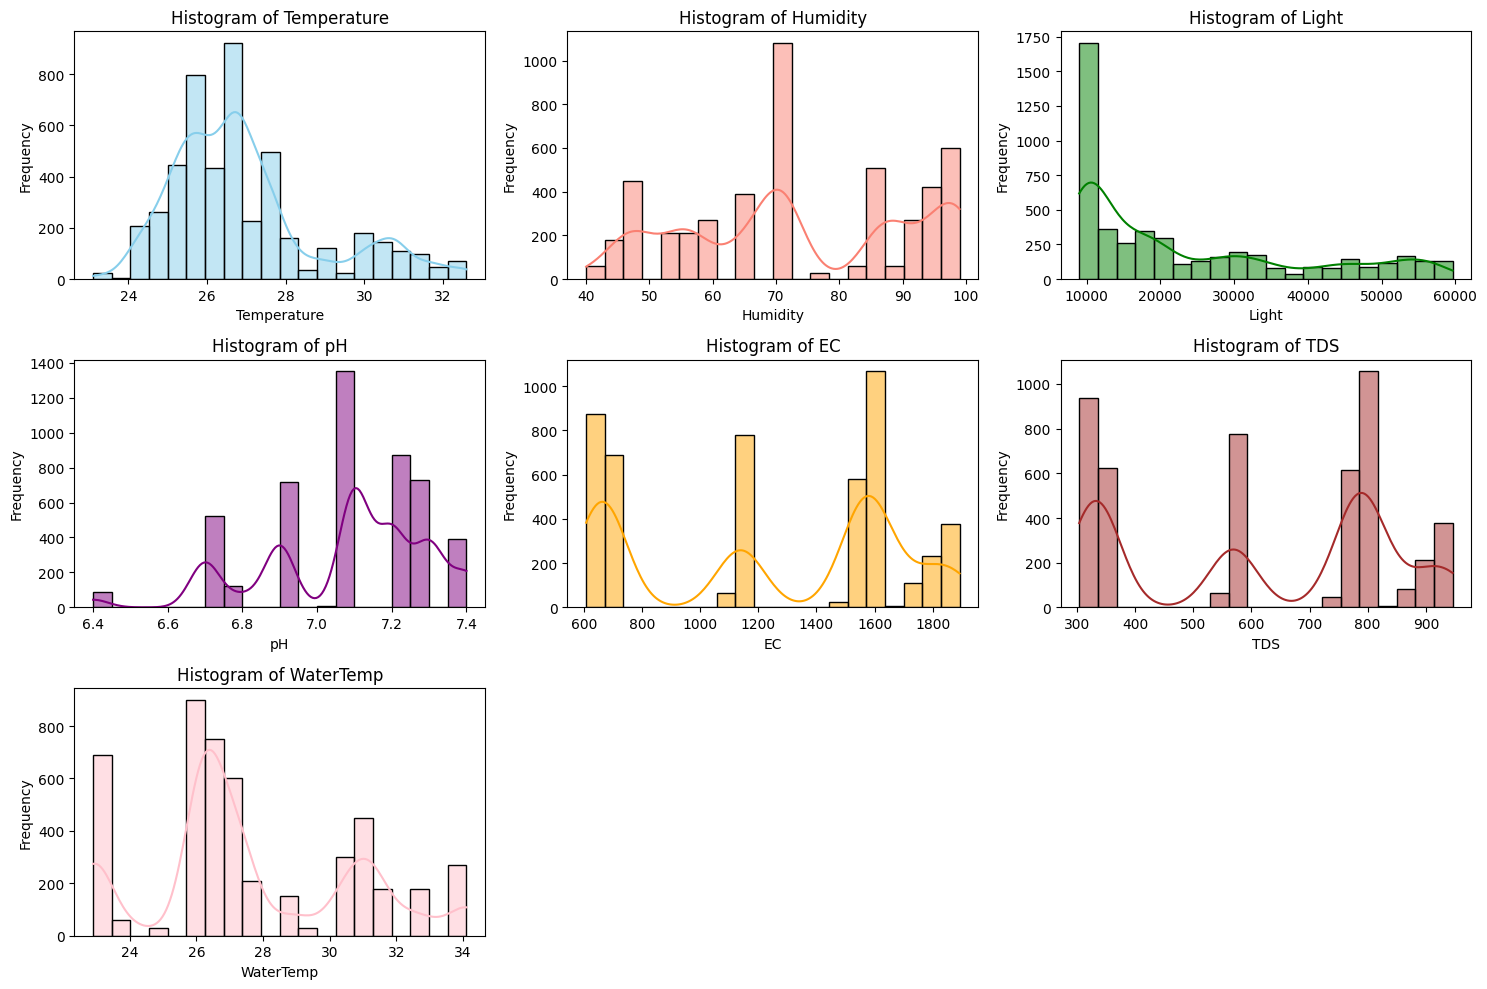

In [12]:
# Plotting histograms
plt.figure(figsize=(15, 10))

# Histogram for 'temperature'
plt.subplot(3, 3, 1)
sns.histplot(df['temperature'], bins=20, kde=True, color='skyblue')
plt.title('Histogram of Temperature')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# Histogram for 'humidity'
plt.subplot(3, 3, 2)
sns.histplot(df['humidity'], bins=20, kde=True, color='salmon')
plt.title('Histogram of Humidity')
plt.xlabel('Humidity')
plt.ylabel('Frequency')

# Histogram for 'light'
plt.subplot(3, 3, 3)
sns.histplot(df['light'], bins=20, kde=True, color='green')
plt.title('Histogram of Light')
plt.xlabel('Light')
plt.ylabel('Frequency')

# Histogram for 'pH'
plt.subplot(3, 3, 4)
sns.histplot(df['pH'], bins=20, kde=True, color='purple')
plt.title('Histogram of pH')
plt.xlabel('pH')
plt.ylabel('Frequency')

# Histogram for 'EC'
plt.subplot(3, 3, 5)
sns.histplot(df['EC'], bins=20, kde=True, color='orange')
plt.title('Histogram of EC')
plt.xlabel('EC')
plt.ylabel('Frequency')

# Histogram for 'TDS'
plt.subplot(3, 3, 6)
sns.histplot(df['TDS'], bins=20, kde=True, color='brown')
plt.title('Histogram of TDS')
plt.xlabel('TDS')
plt.ylabel('Frequency')

# Histogram for 'WaterTemp'
plt.subplot(3, 3, 7)
sns.histplot(df['WaterTemp'], bins=20, kde=True, color='pink')
plt.title('Histogram of WaterTemp')
plt.xlabel('WaterTemp')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Visualisasi Terhadap Hari

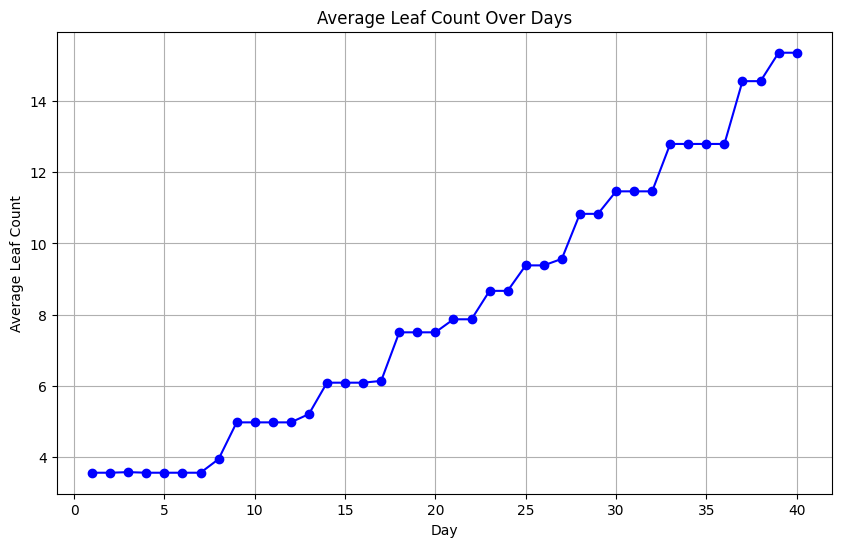

In [13]:
# Group by 'day' and calculate the mean of 'LeafCount'
average_leaf_count = df.groupby('day')['LeafCount'].mean().reset_index()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(average_leaf_count['day'], average_leaf_count['LeafCount'], marker='o', linestyle='-', color='b')

# Adding titles and labels
plt.title('Average Leaf Count Over Days')
plt.xlabel('Day')
plt.ylabel('Average Leaf Count')

# Display the plot
plt.grid(True)
plt.show()

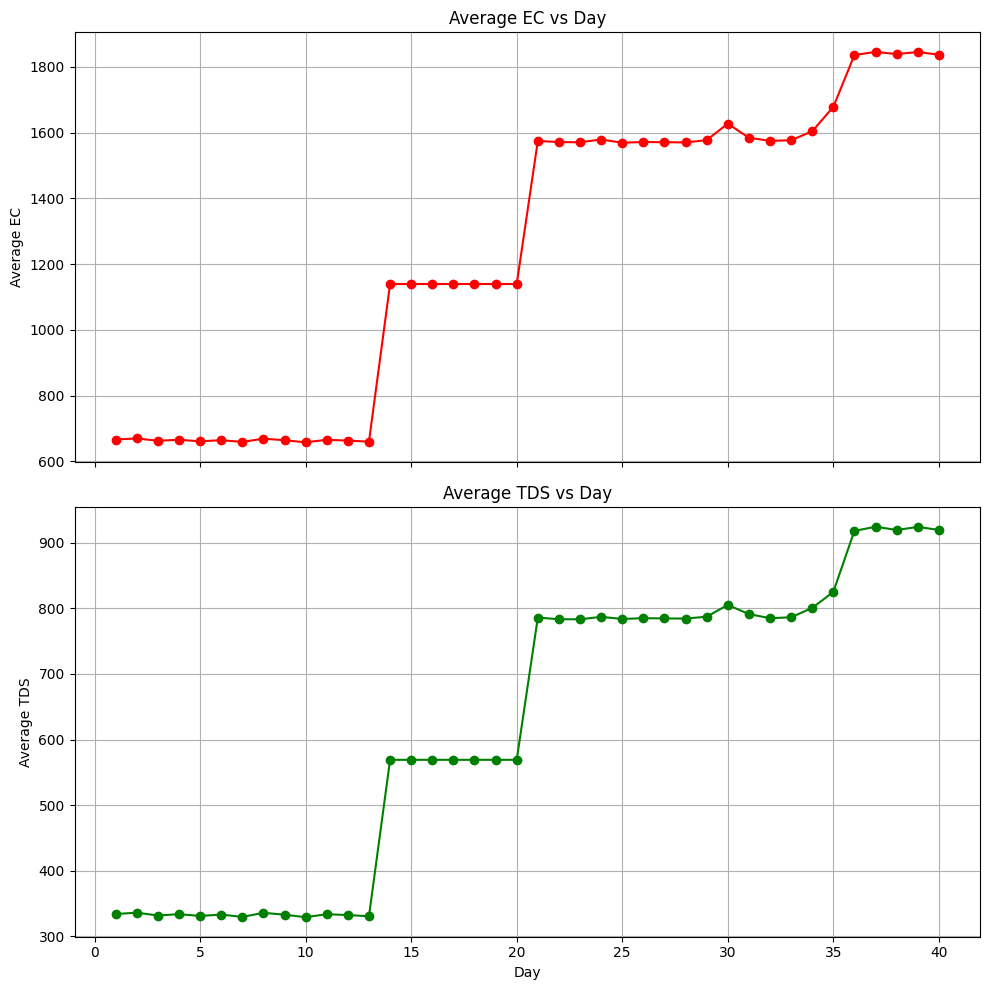

In [14]:
# Group by 'day' and calculate the mean of 'EC' and 'TDS'
average_values = df.groupby('day')[['EC', 'TDS']].mean().reset_index()

# Creating the subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Plotting average EC vs day
axs[0].plot(average_values['day'], average_values['EC'], marker='o', linestyle='-', color='r')
axs[0].set_title('Average EC vs Day')
axs[0].set_ylabel('Average EC')
axs[0].grid(True)

# Plotting average TDS vs day
axs[1].plot(average_values['day'], average_values['TDS'], marker='o', linestyle='-', color='g')
axs[1].set_title('Average TDS vs Day')
axs[1].set_xlabel('Day')
axs[1].set_ylabel('Average TDS')
axs[1].grid(True)

# Displaying the plots
plt.tight_layout()
plt.show()

#### Visualisasi dengan Jumlah Daun

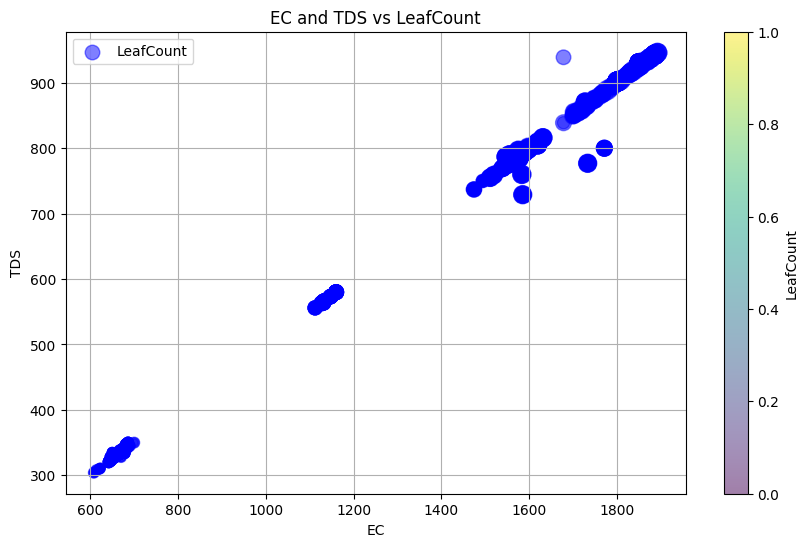

In [15]:
# Plotting EC vs TDS with LeafCount as marker size
plt.figure(figsize=(10, 6))
plt.scatter(df['EC'], df['TDS'], s=df['LeafCount']*10, alpha=0.5, c='blue', label='LeafCount')
plt.title('EC and TDS vs LeafCount')
plt.xlabel('EC')
plt.ylabel('TDS')
plt.colorbar(label='LeafCount')
plt.legend()

plt.grid(True)
plt.show()

# 3. Data Preparation

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          4800 non-null   int64  
 1   hole         4800 non-null   int64  
 2   time         4800 non-null   float64
 3   temperature  4800 non-null   float64
 4   humidity     4800 non-null   int64  
 5   light        4800 non-null   int64  
 6   pH           4800 non-null   float64
 7   EC           4800 non-null   int64  
 8   TDS          4800 non-null   int64  
 9   WaterTemp    4800 non-null   float64
 10  LeafCount    4800 non-null   int64  
dtypes: float64(4), int64(7)
memory usage: 412.6 KB


In [17]:
df_copy = df.copy()

In [18]:
df_copy['time']

0        9.28
1        9.29
2        9.31
3        9.32
4        9.33
        ...  
4795    16.38
4796    16.42
4797    16.43
4798    16.44
4799    16.45
Name: time, Length: 4800, dtype: float64

In [19]:
# Tambahkan "0" di depan nilai yang hanya satu digit di bagian jam
df_copy['time'] = df_copy['time'].apply(lambda x: '{:.2f}'.format(x))

# Konversi 'time' ke format waktu yang benar
df_copy['time'] = pd.to_datetime(df_copy['time'], format='%H.%M').dt.time

In [20]:
df_copy

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,LeafCount
0,1,1,09:28:00,25.1,89,28330,6.7,686,343,26.8,4
1,1,2,09:29:00,25.3,89,29231,6.7,686,343,26.8,3
2,1,3,09:31:00,25.5,89,27850,6.7,686,343,26.8,3
3,1,4,09:32:00,25.7,89,25030,6.7,678,334,26.8,3
4,1,5,09:33:00,25.9,89,22280,6.7,686,343,26.8,4
...,...,...,...,...,...,...,...,...,...,...,...
4795,40,6,16:38:00,26.7,87,13640,7.4,1851,930,26.3,13
4796,40,7,16:42:00,26.8,87,14750,7.4,1801,902,26.3,15
4797,40,8,16:43:00,26.7,87,18860,7.4,1886,943,26.3,18
4798,40,9,16:44:00,25.9,87,12970,7.4,1801,902,26.3,15


In [33]:
df_copy.columns

Index(['day', 'hole', 'time', 'temperature', 'humidity', 'light', 'pH', 'EC',
       'TDS', 'WaterTemp', 'LeafCount'],
      dtype='object')

In [38]:
df_prep = df_copy.copy()

In [39]:
df_prep = df_prep[['day', 'time', 'LeafCount']]

In [40]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   day        4800 non-null   int64 
 1   time       4800 non-null   object
 2   LeafCount  4800 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 112.6+ KB


In [41]:
print(df_prep)

      day      time  LeafCount
0       1  09:28:00          4
1       1  09:29:00          3
2       1  09:31:00          3
3       1  09:32:00          3
4       1  09:33:00          4
...   ...       ...        ...
4795   40  16:38:00         13
4796   40  16:42:00         15
4797   40  16:43:00         18
4798   40  16:44:00         15
4799   40  16:45:00         14

[4800 rows x 3 columns]


In [42]:
# Tentukan tanggal awal
start_date = pd.to_datetime('2024-01-01')

In [43]:
# Ubah kolom 'time' menjadi string
df_prep['time'] = df_prep['time'].astype(str)

# Buat kolom 'datetime' dengan menambahkan 'day' ke tanggal awal dan menggabungkan dengan 'time'
df_prep['datetime'] = df_prep.apply(lambda row: start_date + pd.Timedelta(days=row['day'] - 1) + pd.to_timedelta(row['time']), axis=1)


In [52]:
print(df_prep.head())

   day      time  LeafCount            datetime
0    1  09:28:00          4 2024-01-01 09:28:00
1    1  09:29:00          3 2024-01-01 09:29:00
2    1  09:31:00          3 2024-01-01 09:31:00
3    1  09:32:00          3 2024-01-01 09:32:00
4    1  09:33:00          4 2024-01-01 09:33:00


### Data Pre-Processing

In [59]:
# Convert to correct data types
df_prep['day'] = df_prep['day'].astype(int)
df_prep['time'] = df_prep['time'].astype(str)
df_prep['LeafCount'] = df_prep['LeafCount'].astype(int)

In [61]:
# Convert to correct data types
df_copy['day'] = df_copy['day'].astype(int)
df_copy['time'] = df_copy['time'].astype(str)
df_copy['LeafCount'] = df_copy['LeafCount'].astype(int)

In [64]:
# Merge the 'datetime' column from df_prep into df_copy
df_model = pd.merge(df_copy, df_prep[['day', 'time', 'LeafCount', 'datetime']], on=['day', 'time', 'LeafCount'], how='inner')

# Debug: Check the result of the merge
print("df_model after merge:")
print(df_model.head())

df_model after merge:
   day  hole      time  temperature  humidity  light   pH   EC  TDS  \
0    1     1  09:28:00         25.1        89  28330  6.7  686  343   
1    1     2  09:29:00         25.3        89  29231  6.7  686  343   
2    1     3  09:31:00         25.5        89  27850  6.7  686  343   
3    1     3  09:31:00         25.5        89  27850  6.7  686  343   
4    1     3  09:31:00         25.5        89  27850  6.7  686  343   

   WaterTemp  LeafCount            datetime  
0       26.8          4 2024-01-01 09:28:00  
1       26.8          3 2024-01-01 09:29:00  
2       26.8          3 2024-01-01 09:31:00  
3       26.8          3 2024-01-01 09:31:00  
4       26.8          3 2024-01-01 09:31:00  


In [65]:
# Set the 'datetime' column as the index and sort it
df_model.set_index('datetime', inplace=True)
df_model = df_model.sort_index()

In [73]:
df_model.duplicated().sum()

3243

In [74]:
# Remove duplicate rows
df_model = df_model.drop_duplicates()

# Debug: Check the number of duplicates after removal
print(f"Number of duplicates after removal: {df_model.duplicated().sum()}")

Number of duplicates after removal: 0


In [75]:
# Ensure that the data is sorted by datetime
df_model = df_model.sort_index()

# Split the data into training (80%) and testing (20%) sets
train_size = int(len(df_model) * 0.8)
train, test = df_model.iloc[:train_size], df_model.iloc[train_size:]

# Debug: Check the split
print(f"Training set length: {len(train)}")
print(f"Test set length: {len(test)}")

Training set length: 3487
Test set length: 872


# Modelling

## ARIMA Model

In [76]:
# Select the 'LeafCount' column as the target variable
train_leafcount = train['LeafCount']
test_leafcount = test['LeafCount']

In [77]:
# Fit the ARIMA model on the training data
arima_order = (5, 1, 0)  # Example order, you may need to adjust this based on AIC/BIC criteria
arima_model = ARIMA(train_leafcount, order=arima_order)
arima_fit = arima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [88]:
# Make predictions on the test set
predictions_arima = arima_fit.forecast(steps=len(test_leafcount))

# Calculate RMSE and MAE for ARIMA
rmse_arima = np.sqrt(mean_squared_error(test_leafcount, predictions_arima))
mae_arima = mean_absolute_error(test_leafcount, predictions_arima)

print(f"ARIMA RMSE: {rmse_arima}")
print(f"ARIMA MAE: {mae_arima}")

ARIMA RMSE: 2.8546267584278806
ARIMA MAE: 2.2704921080675597


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


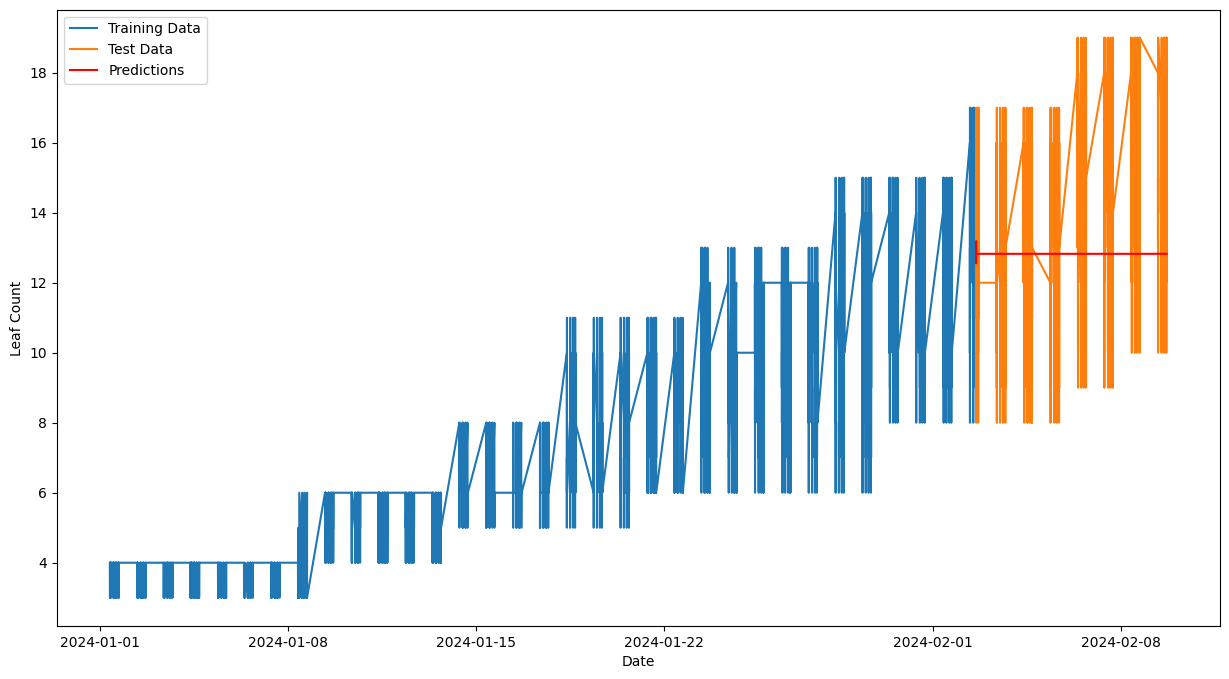

In [89]:
# Plot the results
plt.figure(figsize=(15, 8))
plt.plot(train.index, train_leafcount, label='Training Data')
plt.plot(test.index, test_leafcount, label='Test Data')
plt.plot(test.index, predictions_arima, label='Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Leaf Count')
plt.legend()
plt.show()

## Prophet Model

In [82]:
# Prepare data for Prophet
train_prophet = train.reset_index()[['datetime', 'LeafCount']].rename(columns={'datetime': 'ds', 'LeafCount': 'y'})
test_prophet = test.reset_index()[['datetime', 'LeafCount']].rename(columns={'datetime': 'ds', 'LeafCount': 'y'})


In [83]:
# Initialize and fit Prophet model
prophet_model = Prophet()
prophet_model.fit(train_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7rlp4fme/a48f5qr_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7rlp4fme/b0xctmwi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75634', 'data', 'file=/tmp/tmp7rlp4fme/a48f5qr_.json', 'init=/tmp/tmp7rlp4fme/b0xctmwi.json', 'output', 'file=/tmp/tmp7rlp4fme/prophet_modelbly4ru83/prophet_model-20240624150135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:01:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:01:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [90]:
# Make predictions on the test set
future = test_prophet[['ds']]
forecast = prophet_model.predict(future)
predictions_prophet = forecast['yhat'].values

In [91]:
# Calculate RMSE and MAE for Prophet
rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], predictions_prophet))
mae_prophet = mean_absolute_error(test_prophet['y'], predictions_prophet)

print(f"Prophet RMSE: {rmse_prophet}")
print(f"Prophet MAE: {mae_prophet}")

Prophet RMSE: 2.4371703810082996
Prophet MAE: 1.917657414453059


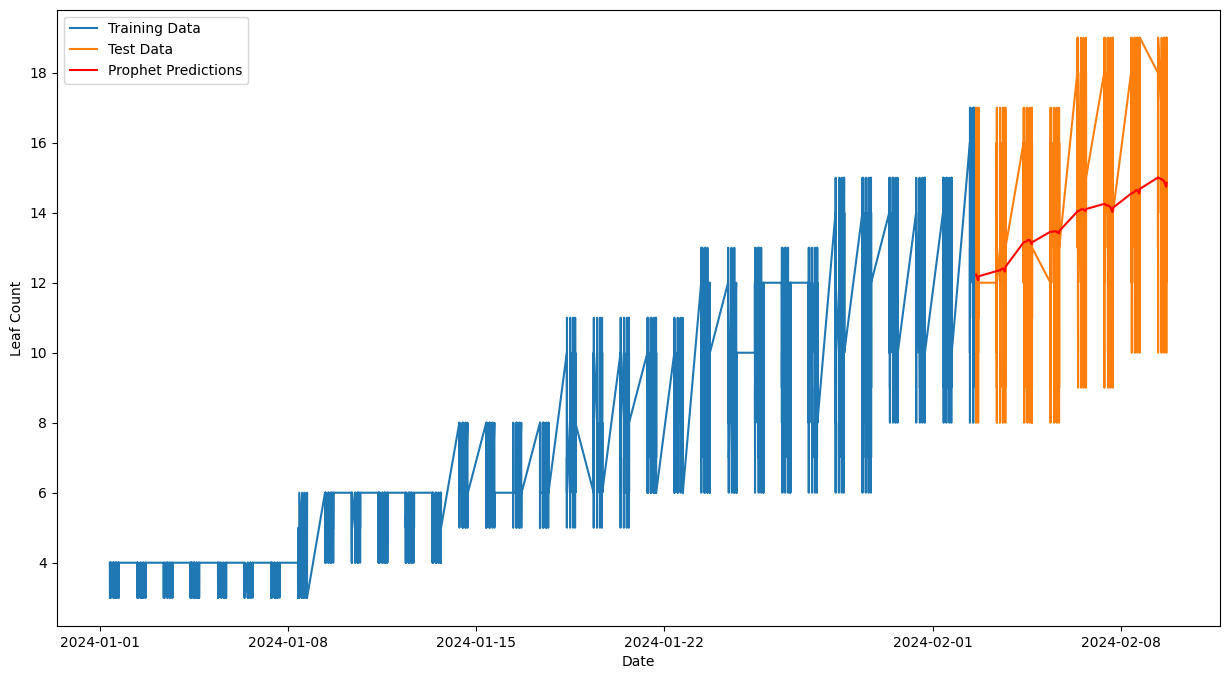

In [92]:
# Plot the results
plt.figure(figsize=(15, 8))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Training Data')
plt.plot(test_prophet['ds'], test_prophet['y'], label='Test Data')
plt.plot(test_prophet['ds'], predictions_prophet, label='Prophet Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Leaf Count')
plt.legend()
plt.show()

## Compare the Models

In [94]:
# Print the comparison of RMSE and MAE
print("Comparison of Forecasting Models (ARIMA vs Prophet):\n")
print(f"{'Metric':<25} {'ARIMA':<15} {'Prophet':<15} {'Improvement':<15}")
print("="*70)
print(f"{'RMSE':<25} {rmse_arima:<15.4f} {rmse_prophet:<15.4f} {(rmse_arima - rmse_prophet):<15.4f}")
print(f"{'MAE':<25} {mae_arima:<15.4f} {mae_prophet:<15.4f} {(mae_arima - mae_prophet):<15.4f}")
print("="*70)


Comparison of Forecasting Models (ARIMA vs Prophet):

Metric                    ARIMA           Prophet         Improvement    
RMSE                      2.8546          2.4372          0.4175         
MAE                       2.2705          1.9177          0.3528         


# Fine-Tuning

## ARIMA Models

### Define the K-Fold, Hyperparamter Grid and Split Data

In [97]:
# Split data into features (X) and target (y)
X = df_model[['temperature', 'humidity', 'light', 'pH', 'EC', 'TDS', 'WaterTemp']]  # Example features
y = df_model['LeafCount']

# Initialize TimeSeriesSplit for K-Fold Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

In [98]:
# Define ranges for ARIMA hyperparameters
p_values = range(0, 3)  # Example range for p
d_values = range(0, 2)  # Example range for d
q_values = range(0, 3)  # Example range for q

### K-Fold Cross-Validation and Hyperparameter Tunning

In [100]:
# Initialize variables to store best model parameters and metrics
best_score = float('inf')
best_params = None
results = []

# Perform K-Fold Cross-Validation and Hyperparameter Tuning
for p in p_values:
    for d in d_values:
        for q in q_values:
            mse_scores = []

            for train_index, val_index in tscv.split(X):
                # Split data
                X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                y_train, y_val = y.iloc[train_index], y.iloc[val_index]

                # Fit ARIMA model
                arima_model = ARIMA(y_train, order=(p, d, q))
                arima_fit = arima_model.fit()

                # Make predictions
                predictions = arima_fit.forecast(steps=len(y_val))

                # Calculate MSE
                mse = mean_squared_error(y_val, predictions)
                mse_scores.append(mse)

            # Calculate average MSE across folds
            avg_mse = np.mean(mse_scores)

            # Record results
            results.append({
                'p': p,
                'd': d,
                'q': q,
                'Average MSE': avg_mse
            })

            # Check if this is the best model so far
            if avg_mse < best_score:
                best_score = avg_mse
                best_params = (p, d, q)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [101]:
# Convert results to DataFrame for easier visualization
results_df = pd.DataFrame(results)

# Sort results by Average MSE
results_df = results_df.sort_values(by='Average MSE')

In [102]:
# Print the results table
print("ARIMA Model Evaluation Results:\n")
print(results_df.to_string(index=False))
print("\nBest ARIMA Model:")
print(f"Parameters: order = {best_params}, Average MSE = {best_score}")

ARIMA Model Evaluation Results:

 p  d  q  Average MSE
 2  1  0     5.372574
 1  1  0     5.640679
 0  1  1     5.651302
 0  1  2     5.685124
 1  1  1     5.687905
 2  1  2     5.688556
 1  1  2     5.689200
 0  1  0     5.700826
 2  1  1     5.701461
 2  0  2     6.025824
 2  0  1     6.031542
 1  0  2     6.036773
 1  0  1     6.039711
 2  0  0    24.905756
 1  0  0    25.085379
 0  0  2    25.190882
 0  0  1    25.206401
 0  0  0    25.228792

Best ARIMA Model:
Parameters: order = (2, 1, 0), Average MSE = 5.3725736374990785


### Train Hyperparamter Model

In [132]:
# Additional features (X) and target variable (y)
X = df_model[['temperature', 'humidity', 'light', 'pH', 'EC', 'TDS', 'WaterTemp']]  # Example features
y = df_model['LeafCount']

# Initialize TimeSeriesSplit for K-fold cross-validation
n_splits = 5  # Number of splits (adjust as needed)
tscv = TimeSeriesSplit(n_splits=n_splits)

In [136]:
# Define function to calculate RMSE and MSE
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    return rmse, mse

In [134]:
# Lists to store evaluation metrics
arima_train_rmse = []
arima_train_mse = []
arima_test_rmse = []
arima_test_mse = []


In [137]:
# Perform K-fold cross-validation for ARIMA model
for train_index, test_index in tscv.split(df_model):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize ARIMA model and fit on training data
    arima_model = ARIMA(endog=y_train, exog=X_train, order=(2, 1, 0))
    arima_fit = arima_model.fit()

    # Make predictions on training set
    arima_train_pred = arima_fit.predict(start=train_index[0], end=train_index[-1], exog=X_train, typ='levels')
    arima_train_rmse_i, arima_train_mse_i = calculate_metrics(y_train, arima_train_pred)
    arima_train_rmse.append(arima_train_rmse_i)
    arima_train_mse.append(arima_train_mse_i)

    # Make predictions on test set
    arima_test_pred = arima_fit.predict(start=test_index[0], end=test_index[-1], exog=X_test, typ='levels')
    arima_test_rmse_i, arima_test_mse_i = calculate_metrics(y_test, arima_test_pred)
    arima_test_rmse.append(arima_test_rmse_i)
    arima_test_mse.append(arima_test_mse_i)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/di

In [138]:
# Print average RMSE and MSE for ARIMA model
print("ARIMA Model with Additional Features:")
print(f"Average Train RMSE: {np.mean(arima_train_rmse)}")
print(f"Average Train MSE: {np.mean(arima_train_mse)}")
print(f"Average Test RMSE: {np.mean(arima_test_rmse)}")
print(f"Average Test MSE: {np.mean(arima_test_mse)}")

ARIMA Model with Additional Features:
Average Train RMSE: 1.1300388827353554
Average Train MSE: 1.4605482064811952
Average Test RMSE: 2.1915355879886955
Average Test MSE: 4.9606778024280915


In [121]:
# Fit ARIMA model with best parameters (order=(2, 1, 0)) on training set
arima_model = ARIMA(y_train, order=(2, 1, 0))
arima_fit = arima_model.fit()

# Make predictions on the test set
y_pred = arima_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, typ='levels')

# Calculate RMSE and MSE on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Test RMSE: 2.994390465717736
Test MSE: 8.96637426118128


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [122]:
print(f"Test RMSE: {rmse}")
print(f"Test MSE: {mse}")

Test RMSE: 2.994390465717736
Test MSE: 8.96637426118128


In [123]:
# Example data (replace with your actual data)
train = df_model[:train_size]
test = df_model[train_size:]

# Example columns (replace with your actual columns)
train_leafcount = train['LeafCount']
test_leafcount = test['LeafCount']

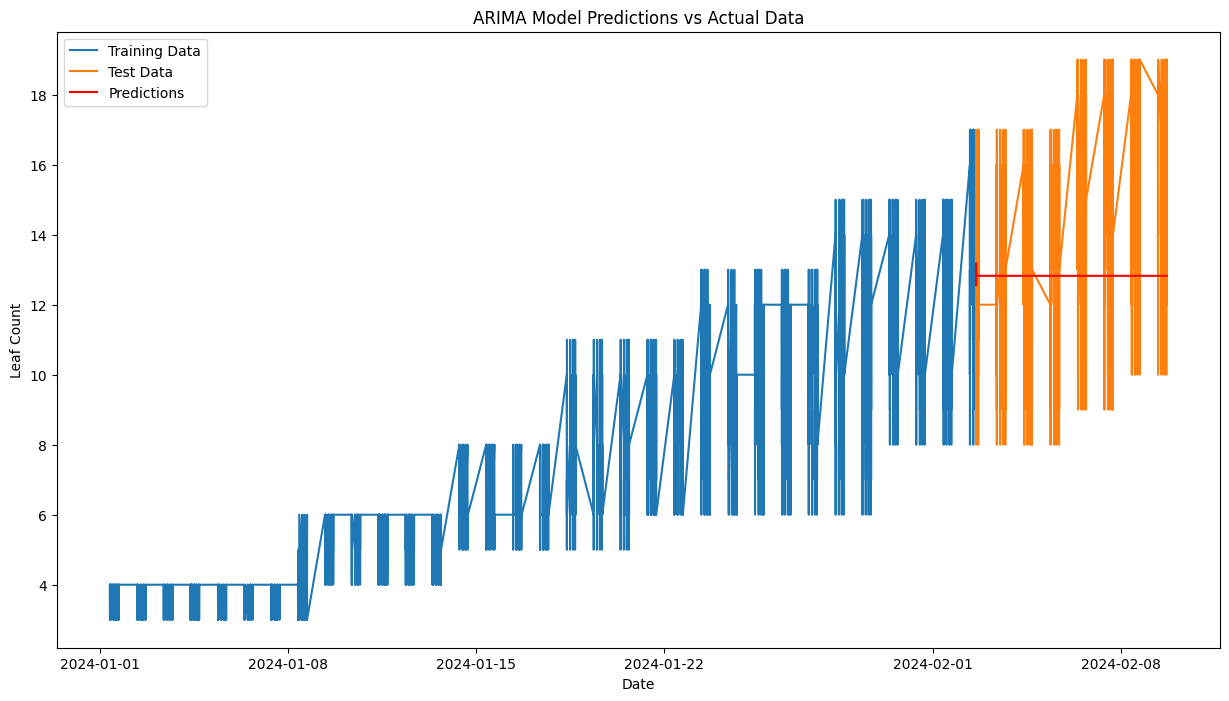

In [124]:
# Plot the results
plt.figure(figsize=(15, 8))
plt.plot(train.index, train_leafcount, label='Training Data')
plt.plot(test.index, test_leafcount, label='Test Data')
plt.plot(test.index, predictions_arima, label='Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Leaf Count')
plt.title('ARIMA Model Predictions vs Actual Data')
plt.legend()
plt.show()

## Prophet Model

### Define and Initialize

In [125]:
# Initialize TimeSeriesSplit for K-fold cross-validation
n_splits = 5  # Number of splits (adjust as needed)
tscv = TimeSeriesSplit(n_splits=n_splits)

In [127]:
# Define function to calculate RMSE and MSE
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    return rmse, mse

In [128]:
# Lists to store evaluation metrics
prophet_train_rmse = []
prophet_train_mse = []
prophet_test_rmse = []
prophet_test_mse = []

### K-Fold Cross-Validation

In [130]:
# Perform K-fold cross-validation for Prophet model
for train_index, test_index in tscv.split(df_model):
    train_data = df_model.iloc[train_index]
    test_data = df_model.iloc[test_index]

    # Prepare data for Prophet
    train_prophet = train_data.reset_index()[['datetime', 'LeafCount']].rename(columns={'datetime': 'ds', 'LeafCount': 'y'})
    test_prophet = test_data.reset_index()[['datetime', 'LeafCount']].rename(columns={'datetime': 'ds', 'LeafCount': 'y'})

    # Initialize Prophet model and fit on training data
    prophet_model = Prophet()
    prophet_model.fit(train_prophet)

    # Make predictions on training set
    prophet_train_forecast = prophet_model.predict(train_prophet)
    prophet_train_pred = prophet_train_forecast['yhat'].values
    prophet_train_rmse_i, prophet_train_mse_i = calculate_metrics(train_prophet['y'], prophet_train_pred)
    prophet_train_rmse.append(prophet_train_rmse_i)
    prophet_train_mse.append(prophet_train_mse_i)

    # Make predictions on test set
    prophet_test_forecast = prophet_model.predict(test_prophet)
    prophet_test_pred = prophet_test_forecast['yhat'].values
    prophet_test_rmse_i, prophet_test_mse_i = calculate_metrics(test_prophet['y'], prophet_test_pred)
    prophet_test_rmse.append(prophet_test_rmse_i)
    prophet_test_mse.append(prophet_test_mse_i)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7rlp4fme/gsqy880w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7rlp4fme/uzg1aimn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2196', 'data', 'file=/tmp/tmp7rlp4fme/gsqy880w.json', 'init=/tmp/tmp7rlp4fme/uzg1aimn.json', 'output', 'file=/tmp/tmp7rlp4fme/prophet_modelug56abhc/prophet_model-20240624153218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:32:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:32:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonali

In [131]:
# Print average RMSE and MSE for Prophet model
print("Prophet Model:")
print(f"Average Train RMSE: {np.mean(prophet_train_rmse)}")
print(f"Average Train MSE: {np.mean(prophet_train_mse)}")
print(f"Average Test RMSE: {np.mean(prophet_test_rmse)}")
print(f"Average Test MSE: {np.mean(prophet_test_mse)}")

Prophet Model:
Average Train RMSE: 0.9907811248120586
Average Train MSE: 1.1337146130278384
Average Test RMSE: 2.0324852999058205
Average Test MSE: 4.214862982375375


# Evaluation

In [141]:
# Define the results in a list of lists format
results = [
    ["Prophet Model",
     np.mean(prophet_train_rmse), np.mean(prophet_train_mse),
     np.mean(prophet_test_rmse), np.mean(prophet_test_mse)],
    ["ARIMA Model",
     np.mean(arima_train_rmse), np.mean(arima_train_mse),
     np.mean(arima_test_rmse), np.mean(arima_test_mse)]
]

# Define headers for the table
headers = ["Model", "Average Train RMSE", "Average Train MSE", "Average Test RMSE", "Average Test MSE"]

# Print the table
print(tabulate(results, headers=headers, tablefmt="pretty"))

+---------------+--------------------+--------------------+--------------------+--------------------+
|     Model     | Average Train RMSE | Average Train MSE  | Average Test RMSE  |  Average Test MSE  |
+---------------+--------------------+--------------------+--------------------+--------------------+
| Prophet Model | 0.9907811248120586 | 1.1337146130278384 | 2.0324852999058205 | 4.214862982375375  |
|  ARIMA Model  | 1.1300388827353554 | 1.4605482064811952 | 2.1915355879886955 | 4.9606778024280915 |
+---------------+--------------------+--------------------+--------------------+--------------------+


# Deployment

In [151]:
# Prepare data for Prophet
train_prophet = train.reset_index()[['datetime', 'LeafCount']].rename(columns={'datetime': 'ds', 'LeafCount': 'y'})
test_prophet = test.reset_index()[['datetime', 'LeafCount']].rename(columns={'datetime': 'ds', 'LeafCount': 'y'})


In [152]:
# Ensure datetime column is accessible after resetting index
train_prophet = train.reset_index()[['datetime', 'LeafCount']].rename(columns={'datetime': 'ds', 'LeafCount': 'y'})
test_prophet = test.reset_index()[['datetime', 'LeafCount']].rename(columns={'datetime': 'ds', 'LeafCount': 'y'})


In [154]:
# Initialize Prophet model
prophet_model = Prophet()

# Fit Prophet model on training data
prophet_model.fit(train_prophet)

num_days_to_forecast = 5  # User input for number of days to forecast

# Forecast for the next num_days_to_forecast days
future_dates = prophet_model.make_future_dataframe(periods=num_days_to_forecast, freq='D')
forecast = prophet_model.predict(future_dates)

# Extract forecasted dates and values
forecast_dates = forecast['ds'].tail(num_days_to_forecast)
forecast_values = forecast['yhat'].tail(num_days_to_forecast)

# Display the forecasted values
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted_LeafCount': forecast_values})
print(f"Forecasting for the next {num_days_to_forecast} days:")
print(forecast_df)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7rlp4fme/o6yg4_ja.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7rlp4fme/faikvr4f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5403', 'data', 'file=/tmp/tmp7rlp4fme/o6yg4_ja.json', 'init=/tmp/tmp7rlp4fme/faikvr4f.json', 'output', 'file=/tmp/tmp7rlp4fme/prophet_modelx8qbaw4n/prophet_model-20240624155217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:52:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:52:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Forecasting for the next 5 days:
                    Date  Forecasted_LeafCount
1924 2024-02-03 14:29:00             12.408279
1925 2024-02-04 14:29:00             13.216747
1926 2024-02-05 14:29:00             13.463295
1927 2024-02-06 14:29:00             14.098174
1928 2024-02-07 14:29:00             14.168399


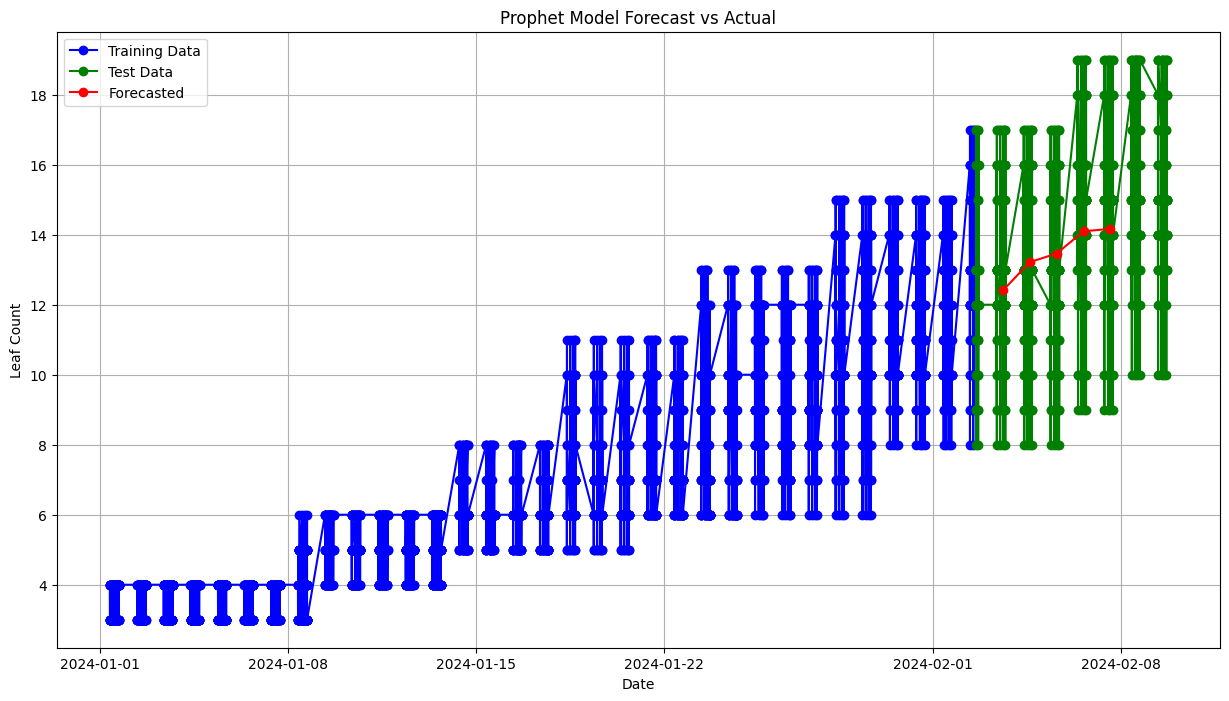

In [155]:
# Plot the results
plt.figure(figsize=(15, 8))

# Training data
plt.plot(train.index, train['LeafCount'], label='Training Data', marker='o', linestyle='-', color='blue')

# Test data (actual values)
plt.plot(test.index, test['LeafCount'], label='Test Data', marker='o', linestyle='-', color='green')

# Forecasted values
plt.plot(forecast_df['Date'], forecast_df['Forecasted_LeafCount'], label='Forecasted', marker='o', linestyle='-', color='red')

plt.xlabel('Date')
plt.ylabel('Leaf Count')
plt.title('Prophet Model Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.show()